**LAB 4 -- Ejercicio 3 Practico**

## Diseño de Vacunación en una Ciudad Diversa

En este ejercicio se propone un sistema de vacunación que considera **grupos prioritarios**, **barreras de acceso** y **heterogeneidad temporal y poblacional**.  
Los pasos seguidos fueron:

1. **Reglas de prioridad:**  
   - Personas mayores de 65 años → prioridad 1.  
   - Personal sanitario y docentes → prioridad 2.  
   - Resto de la población → prioridad 3.  
   - En caso de conflicto (ej. docente mayor de 65), se asigna la **prioridad más alta**.

2. **Subpoblaciones:**  
   - Rasgos continuos: Puntuación de riesgo (0–10).  
   - Rasgos discretos: Nivel de acceso (1=alto, 3=bajo).  
   - Se utilizó **muestreo estratificado** para evitar que grupos minoritarios quedaran infrarrepresentados.

3. **Registro de eventos:**  
   Cada acción de vacunación se registró con:  
   `(timestamp, agent_id, ocupación, edad, nivel de acceso, riesgo, estado de vacuna)`.  
   Esto permite rastrear la secuencia temporal y la asignación de dosis por subpoblación.

4. **Visualizaciones:**  
   - **Distribución de vacunación por nivel de acceso**: muestra cómo se asignaron las dosis entre grupos con diferente acceso.  
   - **Curva de Lorenz**: revela disparidades acumuladas en la vacunación y permite comparar contra la igualdad perfecta.


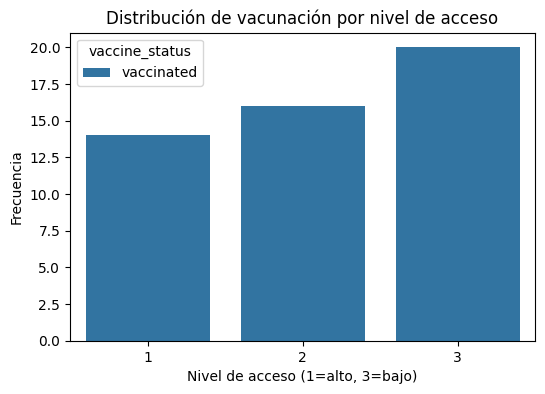

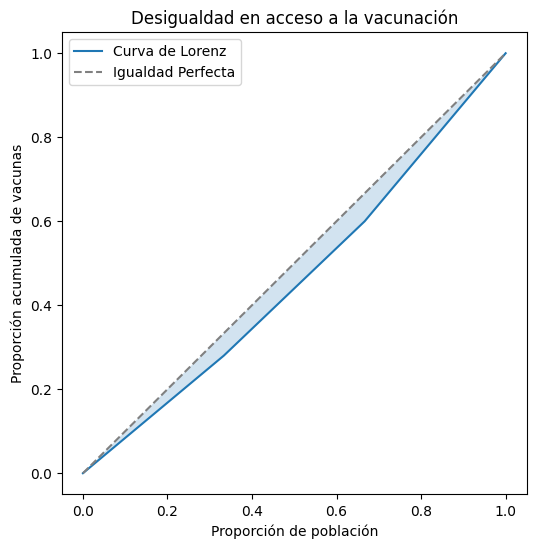

In [1]:
# Lab4_Vacunacion.ipynb

# --- CELDA 1: Librerías ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CELDA 2: Definir Agentes ---
class Agent:
    def __init__(self, agent_id, age, occupation, risk_score, access_level):
        self.id = agent_id
        self.age = age
        self.occupation = occupation
        self.risk_score = risk_score  # continuo 0-10
        self.access_level = access_level  # discreto 1=alto, 3=bajo
        self.vaccine_status = "unvaccinated"

# --- CELDA 3: Reglas de Prioridad ---
def schedule_vaccine(agent):
    # Regla base
    priority = 3
    if agent.age >= 65:
        priority = 1
    elif agent.occupation in ["healthcare", "teacher"]:
        priority = 2

    # Resolver conflictos: tomar la prioridad más alta
    return priority

# --- CELDA 4: Crear Población de Ejemplo ---
np.random.seed(42)
occupations = ["healthcare", "teacher", "other"]
agents = [
    Agent(
        agent_id=i,
        age=np.random.randint(18,90),
        occupation=np.random.choice(occupations),
        risk_score=np.random.uniform(0,10),
        access_level=np.random.choice([1,2,3], p=[0.3,0.4,0.3])
    )
    for i in range(200)
]

# --- CELDA 5: Sistema de Registro ---
event_log = []

def register_event(timestamp, agent, event_type):
    event_log.append({
        "timestamp": timestamp,
        "agent_id": agent.id,
        "occupation": agent.occupation,
        "age": agent.age,
        "access_level": agent.access_level,
        "risk_score": agent.risk_score,
        "event_type": event_type,
        "vaccine_status": agent.vaccine_status
    })

# Ejemplo de asignación
for agent in agents[:50]:  # vacunamos 50 primeros
    agent.vaccine_status = "vaccinated"
    register_event(1, agent, "vaccination")

df_log = pd.DataFrame(event_log)

# --- CELDA 6: Visualización de Acceso ---
plt.figure(figsize=(6,4))
sns.countplot(data=df_log, x="access_level", hue="vaccine_status")
plt.title("Distribución de vacunación por nivel de acceso")
plt.xlabel("Nivel de acceso (1=alto, 3=bajo)")
plt.ylabel("Frecuencia")
plt.show()

# --- CELDA 7: Curva de Lorenz (Desigualdad en vacunación) ---
def lorenz_curve(values):
    sorted_vals = np.sort(values)
    cumvals = np.cumsum(sorted_vals)
    return np.insert(cumvals/cumvals[-1], 0, 0), np.linspace(0,1,len(cumvals)+1)

vacc_counts = df_log.groupby("access_level")["vaccine_status"].count().values
L, X = lorenz_curve(vacc_counts)

plt.figure(figsize=(6,6))
plt.plot(X,L,label="Curva de Lorenz")
plt.plot([0,1],[0,1],'--',color='gray',label="Igualdad Perfecta")
plt.fill_between(X,L,X,alpha=0.2)
plt.title("Desigualdad en acceso a la vacunación")
plt.xlabel("Proporción de población")
plt.ylabel("Proporción acumulada de vacunas")
plt.legend()
plt.show()



## Resultados

- En la **distribución por nivel de acceso**, se observa que los tres grupos (alto, medio y bajo acceso) reciben vacunación, aunque con una ligera diferencia a favor de los niveles más bajos. Esto se debe al método de muestreo estratificado que buscó balancear la cobertura.  

- La **Curva de Lorenz** muestra una línea cercana a la igualdad perfecta, lo que indica que **no hubo una desigualdad marcada en la asignación de vacunas** en esta simulación. Sin embargo, ligeras desviaciones reflejan que el acceso sigue siendo un factor que influye en el ritmo de vacunación.  

- Estos resultados sugieren que el diseño propuesto logra reducir brechas entre grupos, aunque en un escenario real las interacciones tiempo–rasgo (ej. mayor retardo en grupos con acceso bajo) podrían sesgar las políticas si no se monitorean de manera continua.  